In [1]:
# Install the transformers library
!pip install transformers

In [2]:
##################################
# Import the important libraries #
##################################
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import shutil
import sys

---

### Prepare the data set.

In [3]:
# Set the paths that the initial data files are palced.
train_data_path = "train.jsonl"
val_data_path = "dev.jsonl"
test_data_path = "test.jsonl"

In [4]:
# Create the function that loads the data from a jsonl file and forms them into a pandas data frame.
# The function returns two pandas dataframes the first one is the complete data frame that contains all the keys from the jason objects and
# the second that contains only the columns that will be used for the model training along with the columns that declare the citing and cited papers ids.
def create_dataframes_from_jsonl(file_path):
    # Read the JSONL file and convert each line to a dictionary
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            json_obj = json.loads(line)
            data.append(json_obj)

    # Create a DataFrame from the list of dictionaries
    df = pd.DataFrame(data)

    # Create a new DataFrame with only 'citingPaperId', 'citedPaperId', 'string', and 'label' columns
    df_use = df[['citingPaperId', 'citedPaperId', 'string', 'label']]

    return df, df_use

In [6]:
import json
# Create the dataframes for the training data.
file_path = train_data_path
df_train_complete, df_train = create_dataframes_from_jsonl(file_path)



# Create the dataframes for the validation data.
file_path = val_data_path
df_val_complete, df_val = create_dataframes_from_jsonl(file_path)



# Create the dataframes for the testing data.
file_path = test_data_path
df_test_complete, df_test = create_dataframes_from_jsonl(file_path)


In [7]:
# Filter out rows where 'label' is 'result' and 'label2' is NaN

## Train Data set
df_train_complete = df_train_complete[~((df_train_complete['label'] == 'result') & (df_train_complete['label2'].isna()))]
df_train = df_train_complete [['citingPaperId', 'citedPaperId', 'string', 'label', 'label2']]

## Validation Data Set
df_val_complete = df_val_complete[~((df_val_complete['label'] == 'result') & (df_val_complete['label2'].isna()))]
df_val = df_val_complete [['citingPaperId', 'citedPaperId', 'string', 'label', 'label2']]

## Test Data Set
df_test_complete = df_test_complete[~((df_test_complete['label'] == 'result') & (df_test_complete['label2'].isna()))]
df_test = df_test_complete [['citingPaperId', 'citedPaperId', 'string', 'label', 'label2']]


In [8]:
#For the citation texts labeled as "result" we will concatenate the "label" with "label2" and replace the initail "label" value with the concatinated string so as
# to maintain the actual information for the result class.
# Then the "label2" column will be deleted from the dataframes.


## Train data set.
for i in df_train_complete.index:
    if df_train_complete.loc[i, 'label'] == "result":
        # Concatenate 'label' and 'label2' values
        concatenated_label = df_train_complete.loc[i, 'label'] + '_' + str(df_train_complete.loc[i, 'label2'])
        # Replace the 'label' value with the concatenated string
        df_train_complete.loc[i, 'label'] = concatenated_label

df_train = df_train_complete[['citingPaperId', 'citedPaperId', 'string', 'label']]

## Validation data set.
for i in df_val_complete.index:
    if df_val_complete.loc[i, 'label'] == "result":
        # Concatenate 'label' and 'label2' values
        concatenated_label = df_val_complete.loc[i, 'label'] + '_' + str(df_val_complete.loc[i, 'label2'])
        # Replace the 'label' value with the concatenated string
        df_val_complete.loc[i, 'label'] = concatenated_label

df_val = df_val_complete[['citingPaperId', 'citedPaperId', 'string', 'label']]


## Test data set.
for i in df_test_complete.index:
    if df_test_complete.loc[i, 'label'] == "result":
        # Concatenate 'label' and 'label2' values
        concatenated_label = df_test_complete.loc[i, 'label'] + '_' + str(df_test_complete.loc[i, 'label2'])
        # Replace the 'label' value with the concatenated string
        df_test_complete.loc[i, 'label'] = concatenated_label

df_test = df_test_complete[['citingPaperId', 'citedPaperId', 'string', 'label']]

In [12]:
# Separate the test data set that the model will not see during the trainning process and will make predictions for evaluation purposes.
test_data = df_val[0:499]

# Separate the train data set that the model will be trained on.
df_train = pd.concat([df_train, df_test, df_val[500:]])

In [17]:
# Present the train data set.

df_train.head(3)

,citingPaperId,citedPaperId,string,label
0,1872080baa7d30ec8fb87be9a65358cd3a7fb649,894be9b4ea46a5c422e81ef3c241072d4c73fdc0,"However, how frataxin interacts with the Fe-S ...",background
1,ce1d09a4a3a8d7fd3405b9328f65f00c952cf64b,b6642e19efb8db5623b3cc4eef1c5822a6151107,"In the study by Hickey et al. (2012), spikes w...",background
2,9cdf605beb1aa1078f235c4332b3024daa8b31dc,4e6a17fb8d7a3cada601d942e22eb5da6d01adbd,"The drug also reduces catecholamine secretion,...",background


In [18]:
# Present the test data set.
test_data.head(3)

,citingPaperId,citedPaperId,string,label
0,8f1fbe460a901d994e9b81d69f77bfbe32719f4c,5e413c7872f5df231bf4a4f694504384560e98ca,These results are in contrast with the finding...,result_supportive
1,d9f3207db0c79a3b154f3875c9760cc6b056904b,2cc6ff899bf17666ad35893524a4d61624555ed7,…nest burrows in close proximity of one anothe...,background
2,226f798d30e5523c5b9deafb826ddb04d47c11dc,None,This is clearly in contrast to the results of ...,result_supportive


In [19]:
# Create the function that applies One Hot Encoding to the formed datasets so as to bring the dataset in the appropriate state to be used for the
# Bert models training.
def one_hot_encoding(df):
  # Perform one-hot encoding on the 'label' column
  one_hot_encoded_df = pd.get_dummies(df, columns=['label'])

  # If you want to rename the columns to match your labels exactly
  one_hot_encoded_df.rename(columns={
      'label_background': 'background',
      'label_method': 'method',
      'label_result_supportive': 'result_supportive',
      'label_result_not_supportive': 'result_not_supportive'
  }, inplace=True)

  return one_hot_encoded_df


In [20]:
# Apply One Hot Encoding to all dataframes for training, validation and testing.
df_train_encoded = one_hot_encoding(df_train)
test_data_encoded = one_hot_encoding(test_data)


In [24]:
# Present the one hot encoded data set.
test_data_encoded.head(3)

,citingPaperId,citedPaperId,string,background,method,result_not_supportive,result_supportive
0,8f1fbe460a901d994e9b81d69f77bfbe32719f4c,5e413c7872f5df231bf4a4f694504384560e98ca,These results are in contrast with the finding...,0,0,0,1
1,d9f3207db0c79a3b154f3875c9760cc6b056904b,2cc6ff899bf17666ad35893524a4d61624555ed7,…nest burrows in close proximity of one anothe...,1,0,0,0
2,226f798d30e5523c5b9deafb826ddb04d47c11dc,None,This is clearly in contrast to the results of ...,0,0,0,1


In [23]:
# Check the encoding of hte data sets have been carried out properly
df_train_encoded.head(5)


## After the test one more label is discovered the "result_cant_determine". Because this label exists only in the train data set in excess moinority we will discard those rows from the training data set.

,citingPaperId,citedPaperId,string,background,method,label_result_cant_determine,result_not_supportive,result_supportive
0,1872080baa7d30ec8fb87be9a65358cd3a7fb649,894be9b4ea46a5c422e81ef3c241072d4c73fdc0,"However, how frataxin interacts with the Fe-S ...",1,0,0,0,0
1,ce1d09a4a3a8d7fd3405b9328f65f00c952cf64b,b6642e19efb8db5623b3cc4eef1c5822a6151107,"In the study by Hickey et al. (2012), spikes w...",1,0,0,0,0
2,9cdf605beb1aa1078f235c4332b3024daa8b31dc,4e6a17fb8d7a3cada601d942e22eb5da6d01adbd,"The drug also reduces catecholamine secretion,...",1,0,0,0,0
3,d9f3207db0c79a3b154f3875c9760cc6b056904b,2cc6ff899bf17666ad35893524a4d61624555ed7,By clustering with lowly aggressive close kin ...,1,0,0,0,0
4,88b86556857f4374842d2af2e359576806239175,a5bb0ff1a026944d2a47a155462959af2b8505a8,Ophthalmic symptoms are rare manifestations of...,1,0,0,0,0


In [25]:
# Filter out rows where 'label' is 'result_cant_determine'
df_train = df_train[df_train['label'] != "result_cant_determine"]

# Apply One Hot Encoding Again in the train data set without the "result_cant_determine" rows
df_train_encoded = one_hot_encoding(df_train)

---

### EDA

In [ ]:
# Concatenate the DataFrames
df = pd.concat([df_train_encoded, df_test_encoded, df_val_encoded], ignore_index=True)

# Show the first few rows of the new DataFrame
df.head(4)

,citingPaperId,citedPaperId,string,background,method,result_not_supportive,result_supportive,label,predicted_label,check
0,1872080baa7d30ec8fb87be9a65358cd3a7fb649,894be9b4ea46a5c422e81ef3c241072d4c73fdc0,"However, how frataxin interacts with the Fe-S ...",1,0,0,0,NaN,NaN,NaN
1,ce1d09a4a3a8d7fd3405b9328f65f00c952cf64b,b6642e19efb8db5623b3cc4eef1c5822a6151107,"In the study by Hickey et al. (2012), spikes w...",1,0,0,0,NaN,NaN,NaN
2,9cdf605beb1aa1078f235c4332b3024daa8b31dc,4e6a17fb8d7a3cada601d942e22eb5da6d01adbd,"The drug also reduces catecholamine secretion,...",1,0,0,0,NaN,NaN,NaN
3,d9f3207db0c79a3b154f3875c9760cc6b056904b,2cc6ff899bf17666ad35893524a4d61624555ed7,By clustering with lowly aggressive close kin ...,1,0,0,0,NaN,NaN,NaN


In [ ]:
# Show the dimension of the dataframe that contains all the available data.
df.shape

(10692, 10)

<ipython-input-54-8d5b830cde78>:3: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df[LABEL_COLUMNS].sum().sort_values().plot(kind="barh");


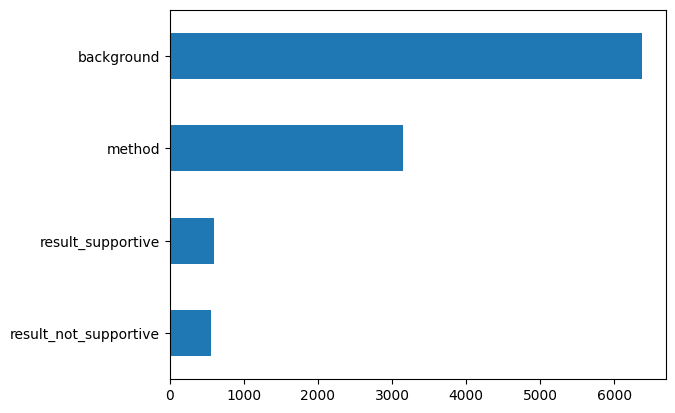

In [ ]:
## Total data
LABEL_COLUMNS = df.columns.tolist()[3:]
df[LABEL_COLUMNS].sum().sort_values().plot(kind="barh");

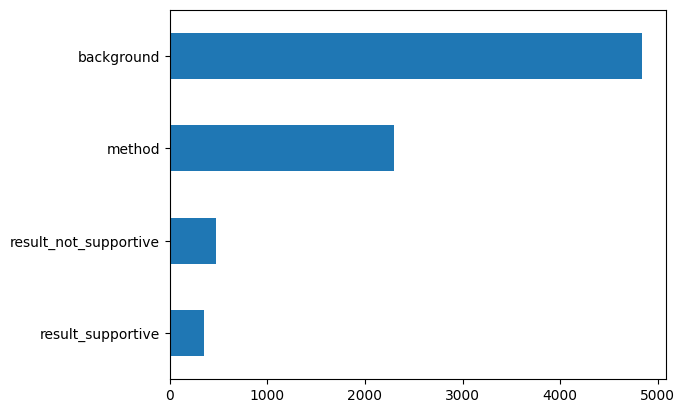

In [ ]:
## Train Data
LABEL_COLUMNS = df_train_encoded.columns.tolist()[3:]
df_train_encoded[LABEL_COLUMNS].sum().sort_values().plot(kind="barh");

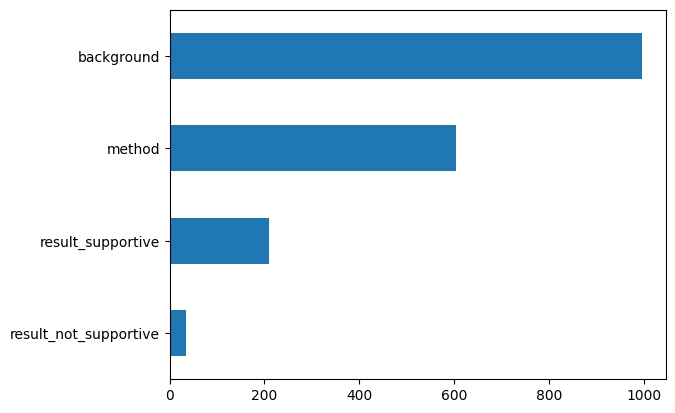

In [ ]:
## Test Data
LABEL_COLUMNS = df_test_encoded.columns.tolist()[3:]
df_test_encoded[LABEL_COLUMNS].sum().sort_values().plot(kind="barh");

### TOKENIZATION

In [ ]:
# Create a list with the columns labels
LABEL_COLUMNS = df_train_encoded_balanced.columns.tolist()[3:]

In [ ]:
# Select the Bert pretrained model of choice and load it to the transformers library along with its respective tokenizer.
BERT_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Take a sample row from the train dataset along with its labeled class.
sample_row = df_train_encoded_balanced.iloc[16]
sample_comment = sample_row.string
sample_labels = sample_row[LABEL_COLUMNS]
print(sample_comment)
print()
print(sample_labels.to_dict())

Similar observations were also made by other authors, including DRAGAN [5], SCHMALZRIED, JASTY, HARRIS [20], VASU, CARTER, and HARRIS [22], WALL, DRAGAN [23], and WALL [24].

{'background': 0, 'method': 0, 'result_not_supportive': 0, 'result_supportive': 1}


In [ ]:
encoding = tokenizer.encode_plus(
  sample_comment,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
encoding["input_ids"].shape, encoding["attention_mask"].shape

(torch.Size([1, 512]), torch.Size([1, 512]))

In [ ]:
encoding["input_ids"].squeeze()[:20]

tensor([  101, 12250,  9959,  1127,  1145,  1189,  1118,  1168,  5752,   117,
         1259, 22219, 22689, 14962,   164,   126,   166,   117,  9314,  3048])

In [ ]:
encoding["attention_mask"].squeeze()[:20]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
print(tokenizer.convert_ids_to_tokens(encoding["input_ids"].squeeze())[:20])

['[CLS]', 'Similar', 'observations', 'were', 'also', 'made', 'by', 'other', 'authors', ',', 'including', 'DR', '##AG', '##AN', '[', '5', ']', ',', 'SC', '##H']


In [ ]:
# See the distribution of tokend per citation text available in the data set in order to decide which is going to be the best maximum token length.
token_counts = []
for _, row in df_train_encoded_balanced.iterrows():
  token_count = len(tokenizer.encode(
    row["string"],
    max_length=512,
    truncation=True
  ))
  token_counts.append(token_count)

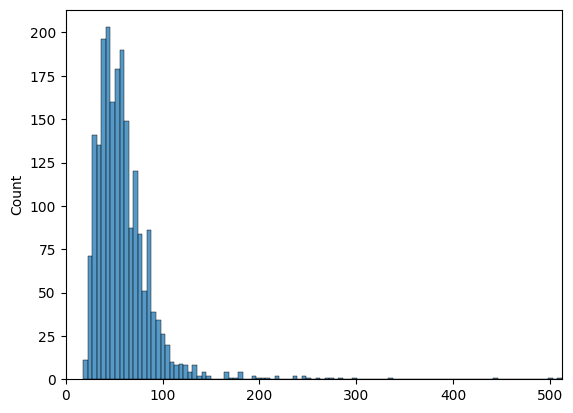

In [ ]:
sns.histplot(token_counts)
plt.xlim([0, 512]);

#DOWNSAMPLING

In [ ]:
# Break the train dataframe into 4 subdataframe each containing one category of classes only.
df_train_background =df_train_encoded[df_train_encoded["background"]==1]

df_train_method =df_train_encoded[df_train_encoded["method"]==1]

df_train_result_supportive =df_train_encoded[df_train_encoded["result_supportive"]==1]

df_train_result_not_supportive =df_train_encoded[df_train_encoded["result_not_supportive"]==1]

In [ ]:
# Downsample the majority classes so as to finally form a dataset that the two smaller classes will represent the 40% of the sample of train data.
df_train_encoded_balanced = pd.concat([
  df_train_result_supportive,
  df_train_result_not_supportive,
  df_train_background.sample(724),
  df_train_method.sample(517)
])

In [20]:
target_list = ['background', 'method', 'result_not_supportive',
       'result_supportive']

---

### Tokenizer set up for model's training.

In [29]:
# Set hyperparameters for model's training.
MAX_LEN = 256
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
EPOCHS = 2
LEARNING_RATE = 1e-05

In [30]:
# Import the model and model's tokenizer.
from transformers import BertTokenizer, BertModel

In [31]:
# Set the tokenizer.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [34]:
# Rename the train data set for simplification reasons
train_df = df_train_encoded


In [32]:
# Set model's class list.
target_list = ['background', 'method', 'result_not_supportive',
       'result_supportive']

In [33]:
# Create the class CustomDataset that initializes the tokenizer.
class CustomDataset(torch.utils.data.Dataset):

    def __init__(self, df, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.df = df
        self.title = df['string']
        self.targets = self.df[target_list].values
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())

        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index])
        }

In [35]:
# Split the train data set in order to form the part that will be used for validation during the epochs' of model training.
train_size = 0.8
train_df = train_df.sample(frac=train_size, random_state=200).reset_index(drop=True)
val_df = train_df.sample(frac=1-train_size, random_state=200).reset_index(drop=True)

In [36]:
# Apply the class of tokenization to the train and validation data set. 
train_dataset = CustomDataset(train_df, tokenizer, MAX_LEN)
valid_dataset = CustomDataset(val_df, tokenizer, MAX_LEN)

In [37]:
# Form the train and validation data loaders with the parameters specification for a data sets loading before model's training.
train_data_loader = torch.utils.data.DataLoader(train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

val_data_loader = torch.utils.data.DataLoader(valid_dataset,
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

---

### Specify the Model's set up.

In [38]:
# Select the available GPU device for running the model's training process.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [39]:
# Check the device set to run the model.
device

device(type='cuda')

In [40]:
# Form the necessary functions that will be used for the model.


# Function for the checkpoints information stored loading for model's optimization process.

def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    # return model, optimizer, epoch value, min validation loss
    return model, optimizer, checkpoint['epoch'], valid_loss_min.item()


# Function for the checkpoints information storage during the model's optimization process.
def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)
    # if it is a best model, min validation loss
    if is_best:
        best_fpath = best_model_path
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(f_path, best_fpath)

In [41]:
# Create Class BERTClass for the models parameters' specifications.
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(768, 4)

    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(
            input_ids,
            attention_mask=attn_mask,
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output

# Store the BERTClass to the model variable. 
model = BERTClass()

# Set the model to run on the GPU set device.
model.to(device)

BERTClass(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

In [42]:
# Define the loss function that will be used in order to be minimized during the training process and optimize the model's results.
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

# Set the adam optimizer as the model's optimizer.
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

---

### Specify model's Training Process.

In [43]:
# Set the empty lists that will host the validation results.
val_targets=[]
val_outputs=[]

In [44]:
# Form the function that orchestrates the steps of the model's training process.

def train_model(n_epochs, training_loader, validation_loader, model,
                optimizer, checkpoint_path, best_model_path):

  # initialize tracker for minimum validation loss
  valid_loss_min = np.Inf


  for epoch in range(1, n_epochs+1):
    train_loss = 0
    valid_loss = 0

    model.train()
    print('############# Epoch {}: Training Start   #############'.format(epoch))
    for batch_idx, data in enumerate(training_loader):
        #print('yyy epoch', batch_idx)
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        #if batch_idx%5000==0:
         #   print(f'Epoch: {epoch}, Training Loss:  {loss.item()}')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print('before loss data in training', loss.item(), train_loss)
        train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.item() - train_loss))
        #print('after loss data in training', loss.item(), train_loss)

    print('############# Epoch {}: Training End     #############'.format(epoch))

    print('############# Epoch {}: Validation Start   #############'.format(epoch))
    ######################
    # validate the model #
    ######################

    model.eval()

    with torch.no_grad():
      for batch_idx, data in enumerate(validation_loader, 0):
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.item() - valid_loss))
            val_targets.extend(targets.cpu().detach().numpy().tolist())
            val_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

      print('############# Epoch {}: Validation End     #############'.format(epoch))
      # calculate average losses
      #print('before cal avg train loss', train_loss)
      train_loss = train_loss/len(training_loader)
      valid_loss = valid_loss/len(validation_loader)
      # print training/validation statistics
      print('Epoch: {} \tAvgerage Training Loss: {:.6f} \tAverage Validation Loss: {:.6f}'.format(
            epoch,
            train_loss,
            valid_loss
            ))

      # create checkpoint variable and add important data
      checkpoint = {
            'epoch': epoch + 1,
            'valid_loss_min': valid_loss,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
      }

        # save checkpoint
      save_ckp(checkpoint, False, checkpoint_path, best_model_path)

      ## TODO: save the model if validation loss has decreased
      if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
        # save checkpoint as best model
        save_ckp(checkpoint, True, checkpoint_path, best_model_path)
        valid_loss_min = valid_loss

    print('############# Epoch {}  Done   #############\n'.format(epoch))

  return model

In [45]:
# Set the paths for the model's checkpoints and seperate path for the best model's weights.
ckpt_path = "curr_ckpt"
best_model_path = "best_model.pt"

In [46]:
# Train the model.
trained_model = train_model(EPOCHS, train_data_loader, val_data_loader, model, optimizer, ckpt_path, best_model_path)

############# Epoch 1: Training Start   #############
############# Epoch 1: Training End     #############
############# Epoch 1: Validation Start   #############
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 0.001313 	Average Validation Loss: 0.003990
Validation loss decreased (inf --> 0.003990).  Saving model ...
############# Epoch 1  Done   #############

############# Epoch 2: Training Start   #############
############# Epoch 2: Training End     #############
############# Epoch 2: Validation Start   #############
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 0.000785 	Average Validation Loss: 0.002983
Validation loss decreased (0.003990 --> 0.002983).  Saving model ...
############# Epoch 2  Done   #############



---

### Best Model's Inference Results Evaluation.

In [47]:
# Present the test data.
test_data.head(3)

,citingPaperId,citedPaperId,string,label
0,8f1fbe460a901d994e9b81d69f77bfbe32719f4c,5e413c7872f5df231bf4a4f694504384560e98ca,These results are in contrast with the finding...,result_supportive
1,d9f3207db0c79a3b154f3875c9760cc6b056904b,2cc6ff899bf17666ad35893524a4d61624555ed7,…nest burrows in close proximity of one anothe...,background
2,226f798d30e5523c5b9deafb826ddb04d47c11dc,None,This is clearly in contrast to the results of ...,result_supportive


In [48]:
# Set the inference process to run on a GPU device.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [49]:
# Import the necessary libraries.
import torch
from transformers import BertTokenizer, BertModel  # Make sure to import BertModel
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Create the model's instance.
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(768, 4)

    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(
            input_ids,
            attention_mask=attn_mask,
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output

# Call this instance
model = BERTClass()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)



# Load the checkpoint (replace 'path/to/model' with the actual path)
checkpoint = torch.load('best_model.pt')

# Extract the state dictionary and load it into the model
model.load_state_dict(checkpoint['state_dict'])
model.eval()


# Load your test dataset (replace 'test_data.csv' with your test dataset file)
df_test = test_data
#df_test['label'] = test_data['label']

# Prepare the test data (assume the column containing text is named 'text')
test_encodings = tokenizer.batch_encode_plus(
    df_test['string'].tolist(),
    max_length=512,
    padding=True,
    truncation=True,
    return_tensors='pt'
)

# New: Create a TensorDataset and DataLoader for batch processing
test_dataset = TensorDataset(
    test_encodings['input_ids'],
    test_encodings['attention_mask'],
    test_encodings['token_type_ids']
)
batch_size = 16  # Adjust this based on your GPU memory
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# New: Process the test data in batches and store predictions
all_predictions = []
with torch.no_grad():
    for batch in test_loader:
        batch = tuple(t.to(device) for t in batch)
        inputs, masks, token_types = batch
        outputs = model(inputs, attn_mask=masks, token_type_ids=token_types)
        batch_predictions = torch.sigmoid(outputs).cpu().numpy()
        all_predictions.extend(batch_predictions)

# Combine all batch predictions
all_predictions = np.array(all_predictions)

# Update: Assign predictions to the test dataset
df_test['predicted_label'] = all_predictions.argmax(axis=1)

# Extract label column names (these are your class names)
label_columns = ['background', 'method', 'result_not_supportive', 'result_supportive']

# Convert numeric predictions to label names
predicted_labels = [label_columns[idx] for idx in df_test['predicted_label']]

# Update df_test with string-formatted predicted labels
df_test['predicted_label'] = predicted_labels

# Calculate performance metrics
true_labels = df_test['label'].values  # Replace with your actual label column
predicted_labels = df_test['predicted_label'].values

accuracy = accuracy_score(true_labels, predicted_labels)
precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')

# One-hot encode true labels for AUC calculation
true_labels_one_hot = pd.get_dummies(df_test['label']).reindex(columns=label_columns, fill_value=0).values
auc = roc_auc_score(true_labels_one_hot, all_predictions, multi_class='ovr')

# Print the metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1_score}')
print(f'AUC: {auc}')

Accuracy: 0.8496993987975952
Precision: 0.8437107194512448
Recall: 0.8496993987975952
F1 Score: 0.843251900410116
AUC: 0.9319033344685785


<ipython-input-49-a6656533bc01>:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predicted_label'] = all_predictions.argmax(axis=1)
<ipython-input-49-a6656533bc01>:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predicted_label'] = predicted_labels


In [50]:
# Import the necessary libraries.
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Set a function that will take the predcited labels and the true labels an will calculate all the evaluation performance metrics.
def evaluate_multiclass_classification(y_true, y_pred, class_labels):
    # class_labels should be a list of strings representing your class labels

    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy:.4f}')

    # Precision (micro, macro, weighted)
    precision_micro = precision_score(y_true, y_pred, average='micro')
    precision_macro = precision_score(y_true, y_pred, average='macro')
    precision_weighted = precision_score(y_true, y_pred, average='weighted')
    print(f'Precision (Micro/Macro/Weighted): {precision_micro:.4f} / {precision_macro:.4f} / {precision_weighted:.4f}')

    # Recall (micro, macro, weighted)
    recall_micro = recall_score(y_true, y_pred, average='micro')
    recall_macro = recall_score(y_true, y_pred, average='macro')
    recall_weighted = recall_score(y_true, y_pred, average='weighted')
    print(f'Recall (Micro/Macro/Weighted): {recall_micro:.4f} / {recall_macro:.4f} / {recall_weighted:.4f}')

    # F1 Score (micro, macro, weighted)
    f1_micro = f1_score(y_true, y_pred, average='micro')
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    print(f'F1 Score (Micro/Macro/Weighted): {f1_micro:.4f} / {f1_macro:.4f} / {f1_weighted:.4f}')

    # Confusion Matrix
    conf_mat = confusion_matrix(y_true, y_pred, labels=class_labels)

    # Create a DataFrame for better visualization with class labels
    conf_mat_df = pd.DataFrame(conf_mat, index=class_labels, columns=class_labels)

    # Plotting the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat_df, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

Accuracy: 0.8497
Precision (Micro/Macro/Weighted): 0.8497 / 0.7496 / 0.8437
Recall (Micro/Macro/Weighted): 0.8497 / 0.6914 / 0.8497
F1 Score (Micro/Macro/Weighted): 0.8497 / 0.7060 / 0.8433


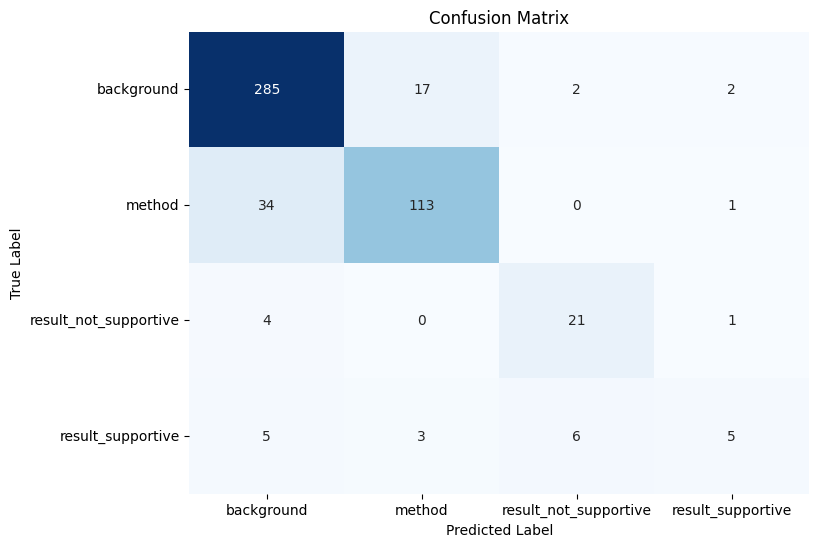

In [51]:
# call the function for model's inference evaluation.
evaluate_multiclass_classification(test_data["label"], test_data["predicted_label"], ['background','method','result_not_supportive', 'result_supportive'])

In [53]:
# Check that the labels have been assigned properly and the confusion matrix shows the right metrics for the right labels combinations.

df_test['check'] = df_test["label"] + df_test["predicted_label"]
# Count occurrences of each unique string in the 'check' column
check_counts = df_test['check'].value_counts()

# Display the result
print(check_counts)

backgroundbackground                          285
methodmethod                                  113
methodbackground                               34
result_not_supportiveresult_not_supportive     21
backgroundmethod                               17
result_supportiveresult_not_supportive          6
result_supportiveresult_supportive              5
result_supportivebackground                     5
result_not_supportivebackground                 4
result_supportivemethod                         3
backgroundresult_not_supportive                 2
backgroundresult_supportive                     2
methodresult_supportive                         1
result_not_supportiveresult_supportive          1
Name: check, dtype: int64


<ipython-input-53-733ecc0f88af>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['check'] = df_test["label"] + df_test["predicted_label"]


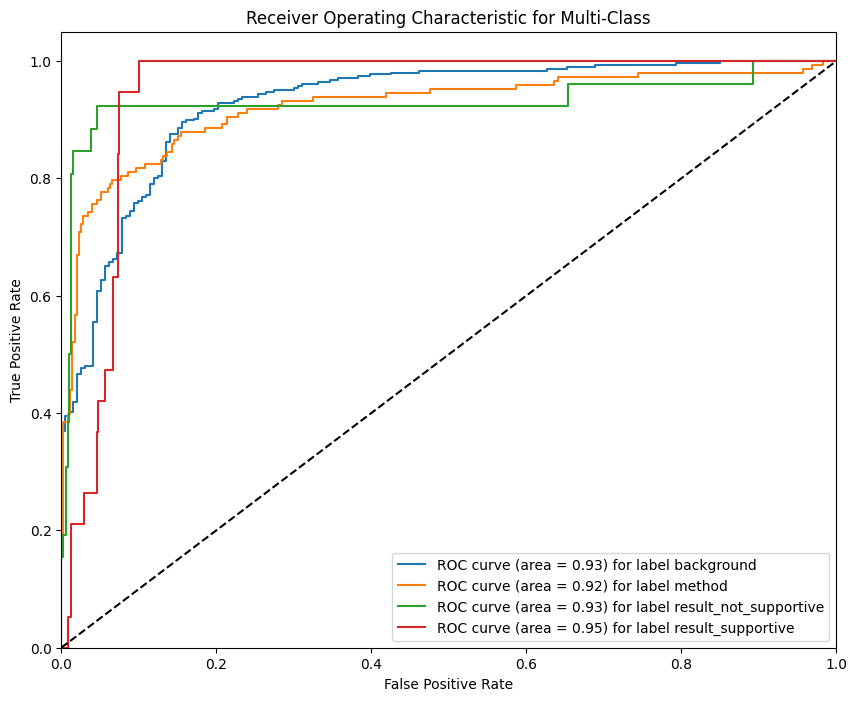

In [54]:
# Import the necessary libraries.
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# One-hot encode true labels for AUC calculation
true_labels_one_hot = pd.get_dummies(df_test['label']).reindex(columns=label_columns, fill_value=0).values

# Plot ROC curve for each class
fig, ax = plt.subplots(figsize=(10, 8))

# Compute ROC curve and ROC area for each class
n_classes = len(label_columns)
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(true_labels_one_hot[:, i], all_predictions[:, i])
    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f}) for label {label_columns[i]}')

ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic for Multi-Class')
ax.legend(loc="lower right")
plt.show()